In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.cuda.is_available()

False

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
transform = transforms.ToTensor()

batch_size = 4
learning_rate = 0.001

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('T-shirt/top', 'Trouser/pants','Pullover shirt','Dress','Coat','Sandal',
           'Shirt','Sneaker','Bag','Ankle boot')

100%|██████████| 26421880/26421880 [00:14<00:00, 1785365.56it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 118140.11it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2183819.28it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25983486.15it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
train_iter = iter(trainset)

image, label = next(train_iter)

image.shape, label

(torch.Size([1, 28, 28]), 9)

In [6]:
torch.min(image).item(), torch.max(image).item()

(0.0, 1.0)

Ankle boot


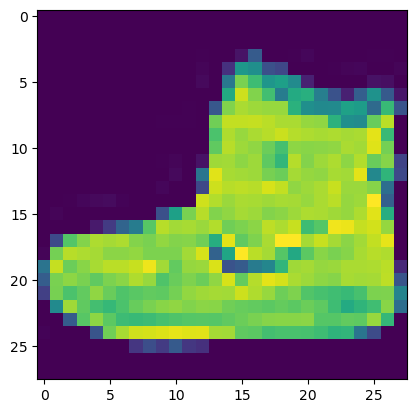

In [7]:
import matplotlib.pyplot as plt
import numpy as np

np_img = image.numpy()
print(classes[label])
plt.imshow(np_img.reshape((28, 28, 1)))

In [8]:
len(trainset), len(testset)

(60000, 10000)

In [9]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [10]:
print(f'Number of batches in the training set: {int(50000 / batch_size)}')

Number of batches in the training set: 12500


In [11]:
print(f'Number of batches in the validation set: {int(10000 / batch_size)}')

Number of batches in the validation set: 2500


In [12]:
type(trainset)

torch.utils.data.dataset.Subset

In [13]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.avg_pool = nn.AvgPool2d(5, 5)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=512, out_features=512)
        self.drop1 = nn.Dropout(p=0.1)

        self.out = nn.Linear(in_features=512, out_features=10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.pool2(x)

        #print(f'Shape before pool: {x.shape}')
        x = self.avg_pool(x)
        #print(f'Shape after pool: {x.shape}')

        x = self.flatten(x)

        x = F.relu(self.fc1(x))

        x = self.out(x)

        return x

In [15]:
net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=5, stride=5, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=512, out_features=10, bias=True)
)

In [16]:
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs).shape}')
    break

input shape: torch.Size([4, 1, 28, 28])
after network shape: torch.Size([4, 10])


In [17]:
num_params = 0
for x in net.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 1,452,042


In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [19]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs) # shape: [batch_size, 10]
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_index % 500 == 499:  # print every 500 batches
      avg_loss_across_batches = running_loss / 500
      avg_acc_across_batches = (running_accuracy / 500) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0


  print()

In [20]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = net(inputs) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100

    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [21]:
num_epochs = 30

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')

    train_one_epoch()
    validate_one_epoch()


print('Finished Training')

Epoch: 1

Batch 500, Loss: 1.164, Accuracy: 56.5%
Batch 1000, Loss: 0.788, Accuracy: 71.4%
Batch 1500, Loss: 0.656, Accuracy: 76.0%
Batch 2000, Loss: 0.637, Accuracy: 76.3%
Batch 2500, Loss: 0.627, Accuracy: 76.8%
Batch 3000, Loss: 0.563, Accuracy: 78.8%
Batch 3500, Loss: 0.534, Accuracy: 79.9%
Batch 4000, Loss: 0.494, Accuracy: 81.6%
Batch 4500, Loss: 0.553, Accuracy: 80.3%
Batch 5000, Loss: 0.517, Accuracy: 81.0%
Batch 5500, Loss: 0.504, Accuracy: 82.2%
Batch 6000, Loss: 0.450, Accuracy: 82.1%
Batch 6500, Loss: 0.499, Accuracy: 81.5%
Batch 7000, Loss: 0.509, Accuracy: 82.0%
Batch 7500, Loss: 0.449, Accuracy: 83.0%
Batch 8000, Loss: 0.489, Accuracy: 81.9%
Batch 8500, Loss: 0.438, Accuracy: 83.4%
Batch 9000, Loss: 0.435, Accuracy: 83.5%
Batch 9500, Loss: 0.471, Accuracy: 83.2%
Batch 10000, Loss: 0.448, Accuracy: 83.4%
Batch 10500, Loss: 0.458, Accuracy: 83.7%
Batch 11000, Loss: 0.405, Accuracy: 84.9%
Batch 11500, Loss: 0.450, Accuracy: 83.2%
Batch 12000, Loss: 0.440, Accuracy: 83.3%
Ba

KeyboardInterrupt: 

In [ ]:
# val accuracy 87.9%